### Import all dependencies

In [1]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [8]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

### Define Few Parameters

In [19]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'data\CT_COVID'
noncovid_path = 'data\CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '\*')
noncovid_files = glob(noncovid_path + '\*')

### Fetch Images and Class Labels from Files (This might take a while)

In [10]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

### Visualize First 40 Images from Data set

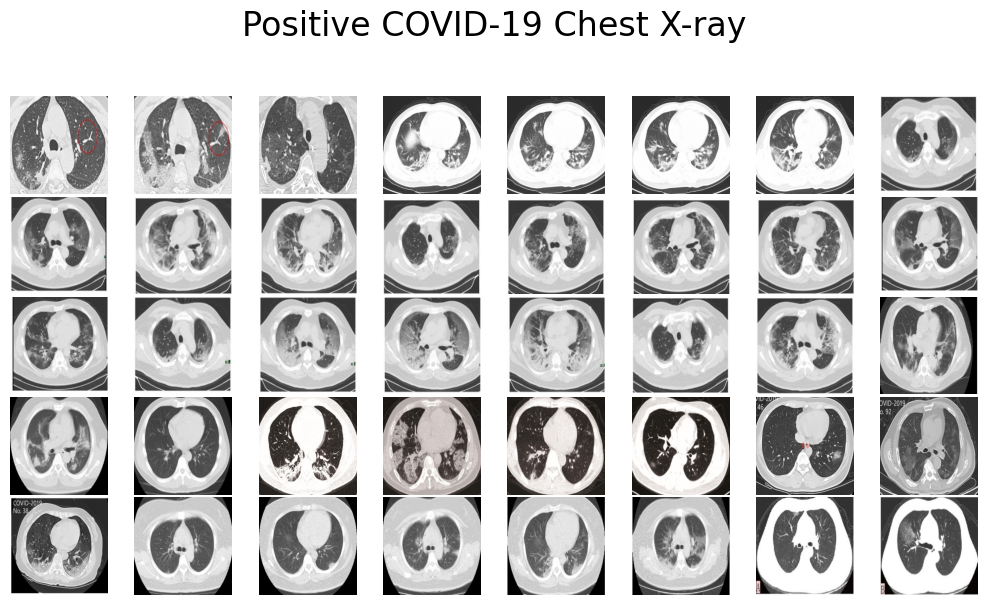

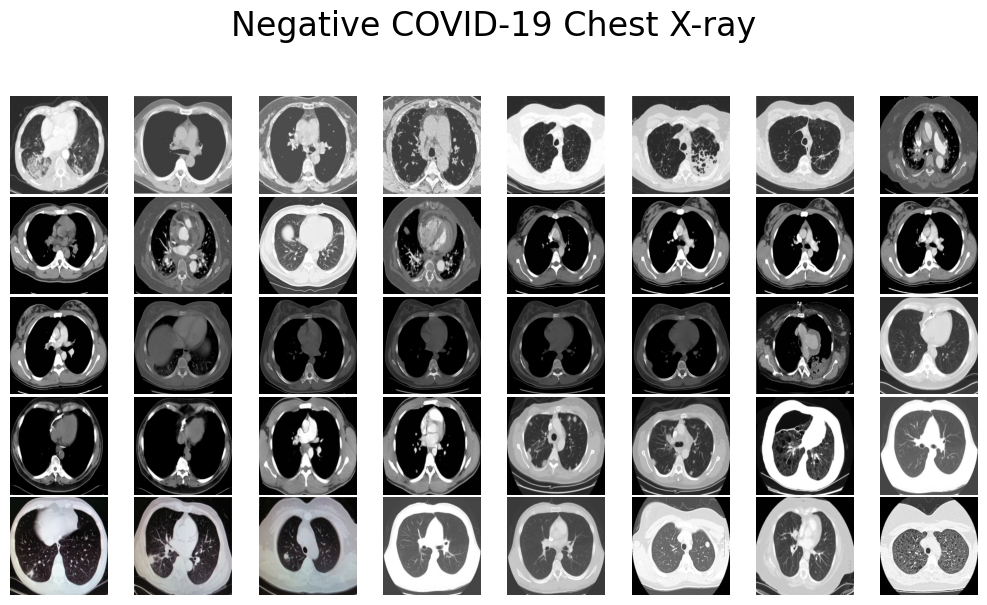

In [11]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [12]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255

In [13]:
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

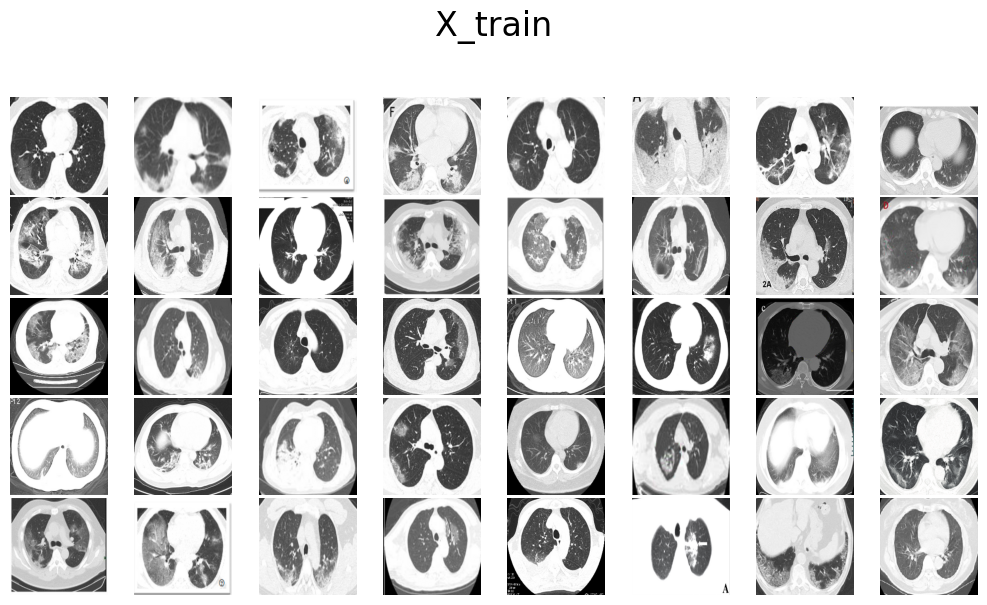

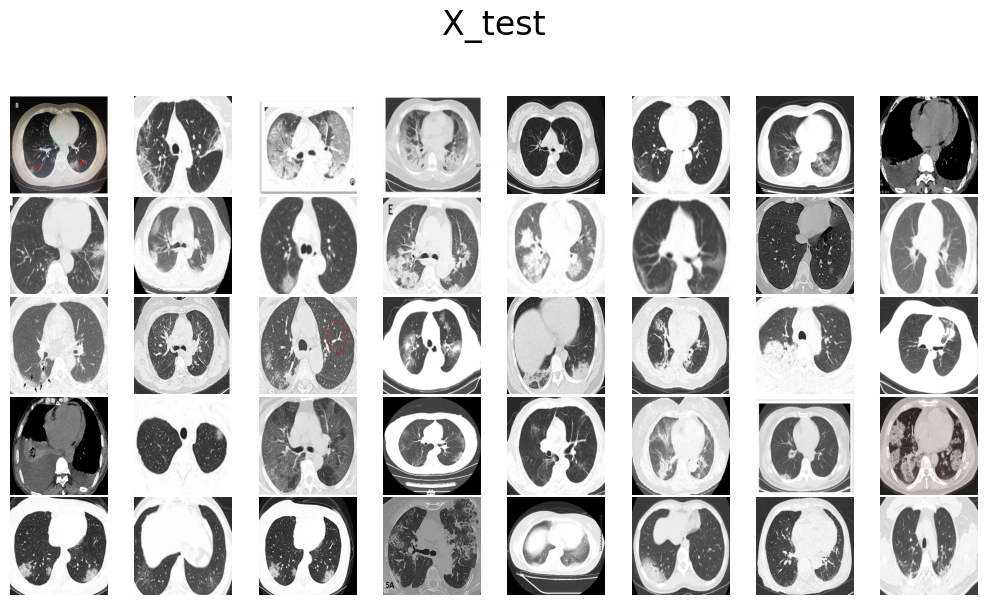

In [15]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [16]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

### **Training the model**

In [21]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=epochs)

Epoch 1/10
18/18 [==============================] - 29s 2s/step - loss: 1.7514 - accuracy: 0.6896 - val_loss: 1.0518 - val_accuracy: 0.7333
Epoch 2/10
18/18 [==============================] - 24s 1s/step - loss: 1.3525 - accuracy: 0.7383 - val_loss: 1.2179 - val_accuracy: 0.7400
Epoch 3/10
18/18 [==============================] - 25s 1s/step - loss: 1.2119 - accuracy: 0.7399 - val_loss: 1.4246 - val_accuracy: 0.6667
Epoch 4/10
18/18 [==============================] - 24s 1s/step - loss: 1.7735 - accuracy: 0.7215 - val_loss: 1.5810 - val_accuracy: 0.7067
Epoch 5/10
18/18 [==============================] - 25s 1s/step - loss: 1.2385 - accuracy: 0.7567 - val_loss: 2.0191 - val_accuracy: 0.6267
Epoch 6/10
18/18 [==============================] - 26s 1s/step - loss: 1.1803 - accuracy: 0.7685 - val_loss: 1.3767 - val_accuracy: 0.6933
Epoch 7/10
18/18 [==============================] - 26s 1s/step - loss: 1.1216 - accuracy: 0.7802 - val_loss: 1.4273 - val_accuracy: 0.6800
Epoch 8/10
18/18 [==

In [22]:
model.save('inceptionv3_chest.h5')

C:\Users\10\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model.save_weights('inceptionv3_chest.hdf5')

In [24]:
model = load_model('inceptionv3_chest.h5')

### **Making Predicions**

In [25]:
y_pred = model.predict(X_test, batch_size=batch_size)

5/5 [==============================] - 6s 1s/step


### Visulaizing First 10 predictions

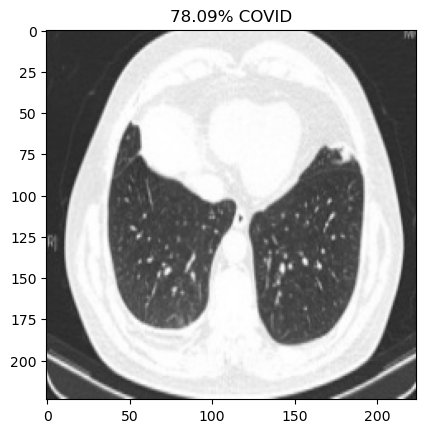

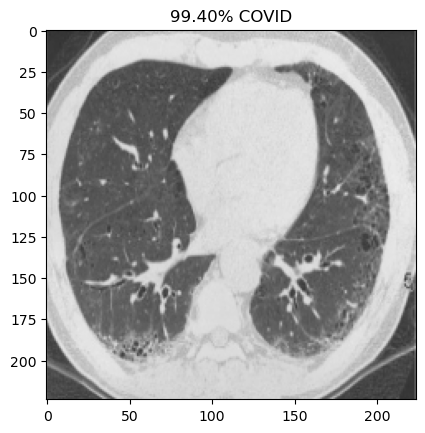

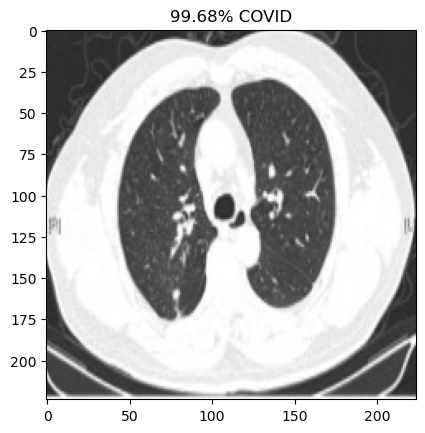

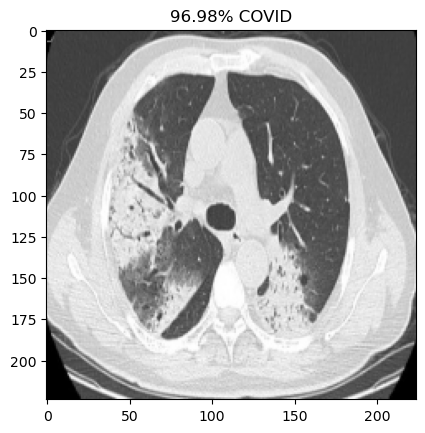

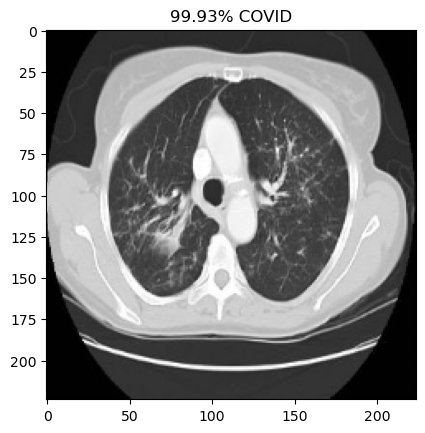

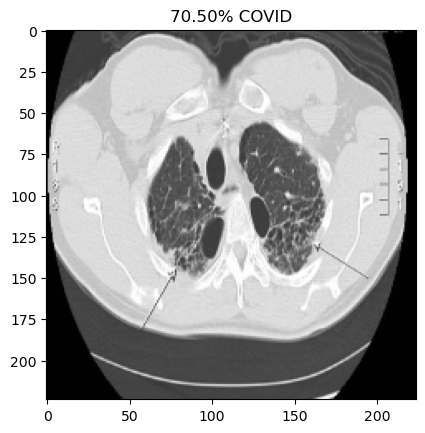

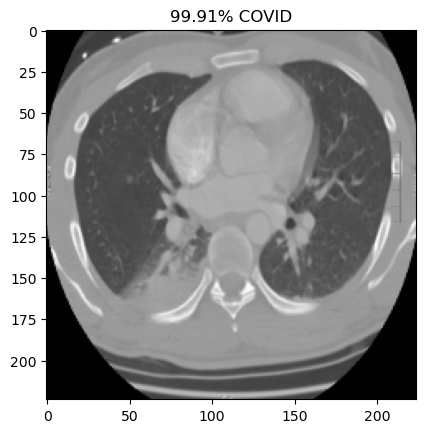

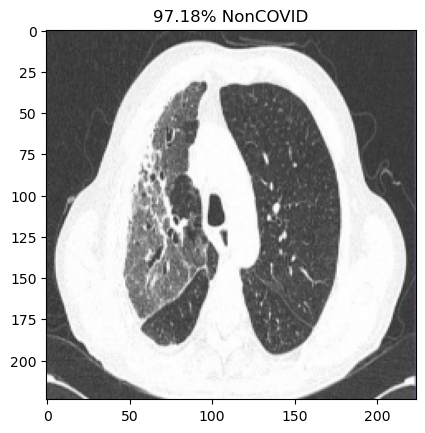

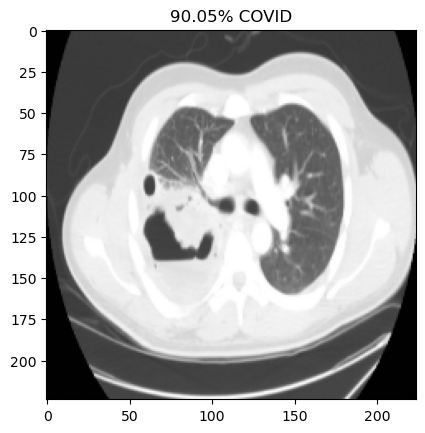

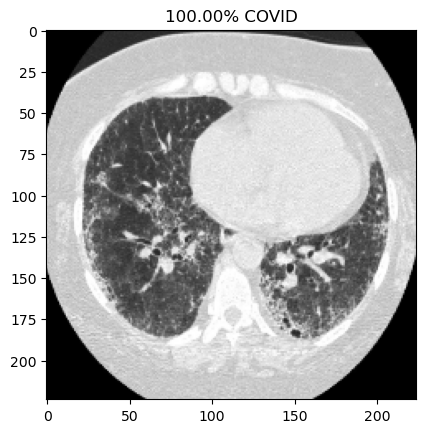

In [26]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [27]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

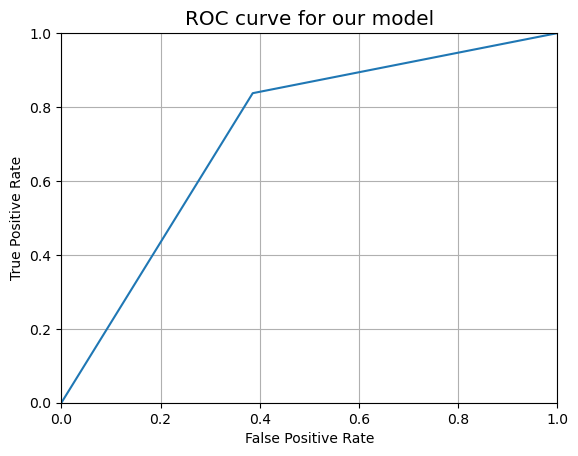

In [28]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


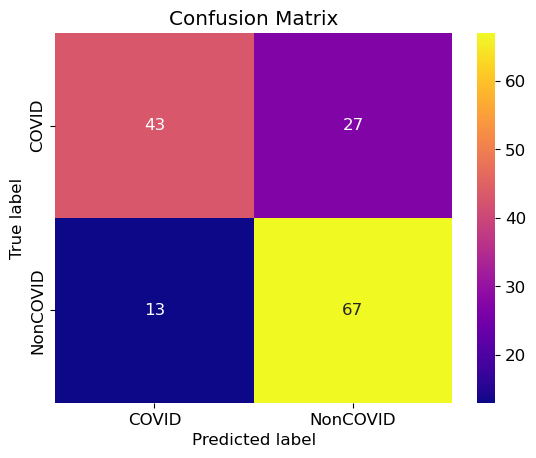

Confusion Matrix with Normalized Values


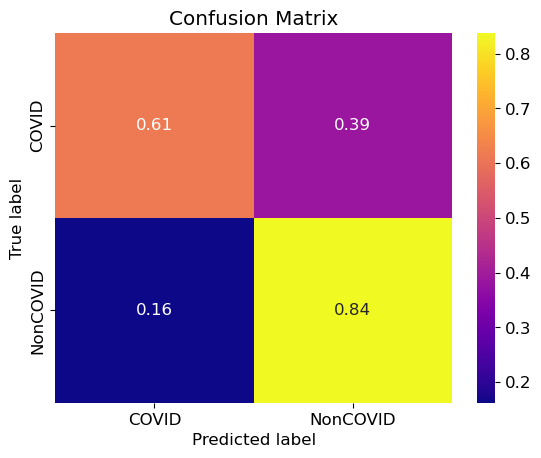

In [29]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        70
           1       0.71      0.84      0.77        80

    accuracy                           0.73       150
   macro avg       0.74      0.73      0.73       150
weighted avg       0.74      0.73      0.73       150



### **Accuracy and Loss Plots**

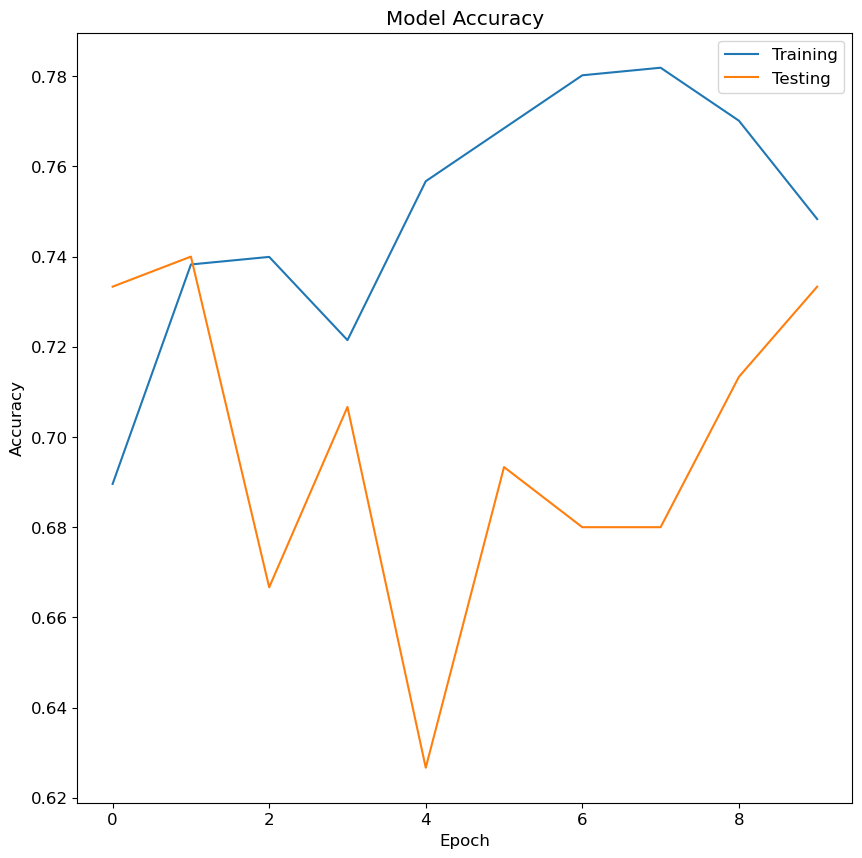

In [31]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_accuracy.png')
plt.show()


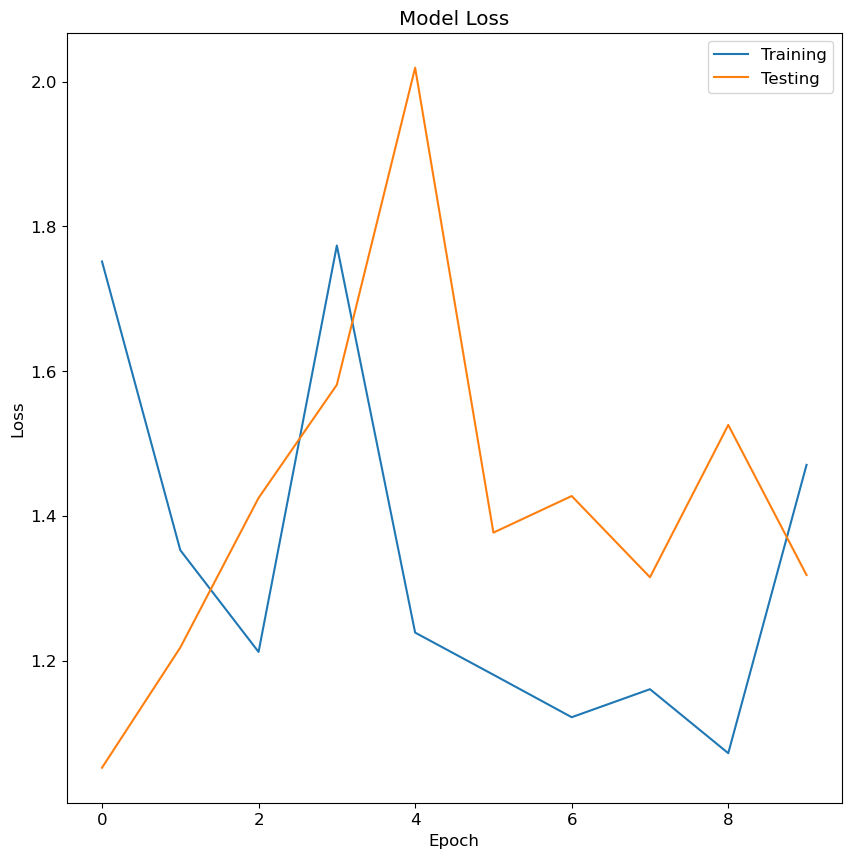

In [32]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_loss.png')
plt.show()